### Read labeled data

In [1]:
import json

rumour_list = []
for x in open("analysis_data/rumour.jsonl", "r").readlines():
    rumour_list.append(json.loads(x.strip()))

nonrumour_list = []
for x in open("analysis_data/nonrumour.jsonl", "r").readlines():
    nonrumour_list.append(json.loads(x.strip()))

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_data/rumour.jsonl'

### Distribution of Rumour tweet

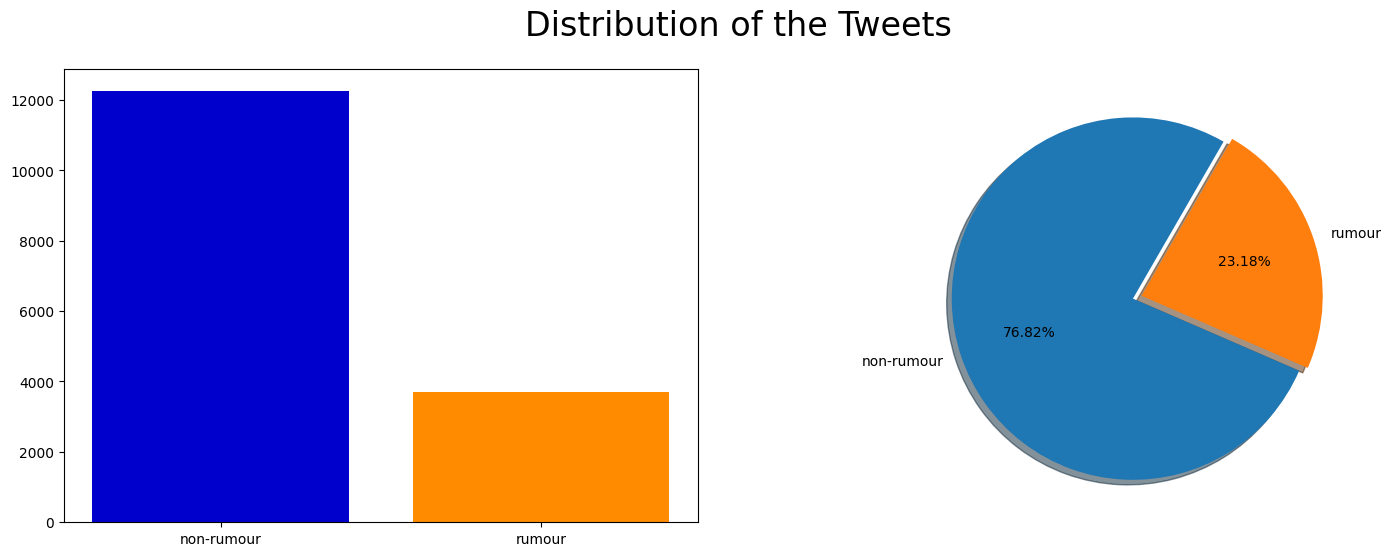

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
count_nonrumour = len(nonrumour_list)
count_rumour = len(rumour_list)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
axes[0].bar(x=[0, 1],
            height=[count_nonrumour, count_rumour],
            tick_label=['non-rumour', 'rumour'],
            color=["mediumblue", "darkorange"],
            )


axes[1].pie([count_nonrumour, count_rumour],
            labels=['non-rumour', 'rumour'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [3]:
# ! pip install nltk

In [4]:
# import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')

### Most common word

In [6]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

rumour_text = [preprocess(x["text"]) for x in rumour_list]
nonrumour_text = [preprocess(x["text"]) for x in nonrumour_list]

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re

tt = TweetTokenizer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word, "v")
    if lemma == word:
        lemma = lemmatizer.lemmatize(word, "n")
    return lemma

stopwords = set(stopwords.words("english"))
stopwords.add("http")
stopwords.add("@user")

rumour_words_count = {}
nonrumour_words_count = {}

for t in rumour_text:
    words = tt.tokenize(t)
    for w in words:
        w = w.lower()
        if re.search(r"[a-z]", w) is not None:
            w = lemmatize(w)
            if w not in stopwords:
                rumour_words_count[w] = rumour_words_count.get(w, 0) + 1
rumour_sorted_words_count = sorted(rumour_words_count.items(), key=lambda wc: wc[1], reverse=True)[:20]

for t in nonrumour_text:
    words = tt.tokenize(t)
    for w in words:
        w = w.lower()
        if re.search(r"[a-z]", w) is not None:
            w = lemmatize(w)
            if w not in stopwords:
                nonrumour_words_count[w] = nonrumour_words_count.get(w, 0) + 1
nonrumour_sorted_words_count = sorted(nonrumour_words_count.items(), key=lambda wc: wc[1], reverse=True)[:20]


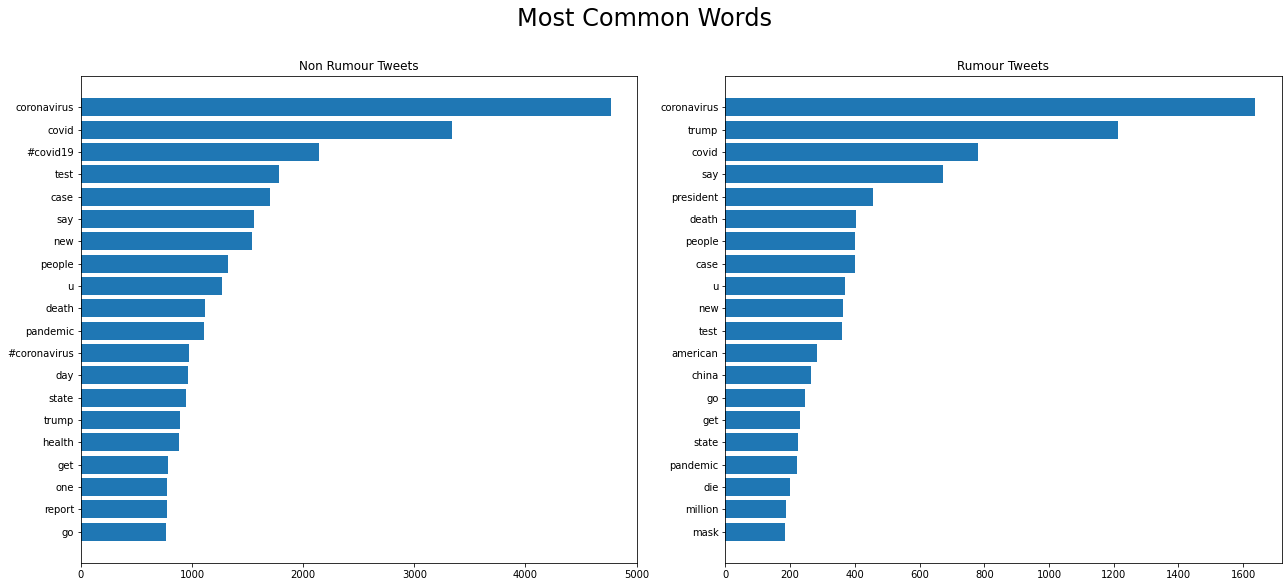

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

axes[0].barh(y=range(20),
             width=[i[1] for i in nonrumour_sorted_words_count],
             tick_label=[i[0] for i in nonrumour_sorted_words_count],
            )
axes[1].barh(y=range(20),
             width=[i[1] for i in rumour_sorted_words_count],
             tick_label=[i[0] for i in rumour_sorted_words_count],
            )
axes[0].invert_yaxis()
axes[1].invert_yaxis()

axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')
fig.suptitle('Most Common Words', fontsize=24, va='baseline')
plt.tight_layout()

### Topic Extraction

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


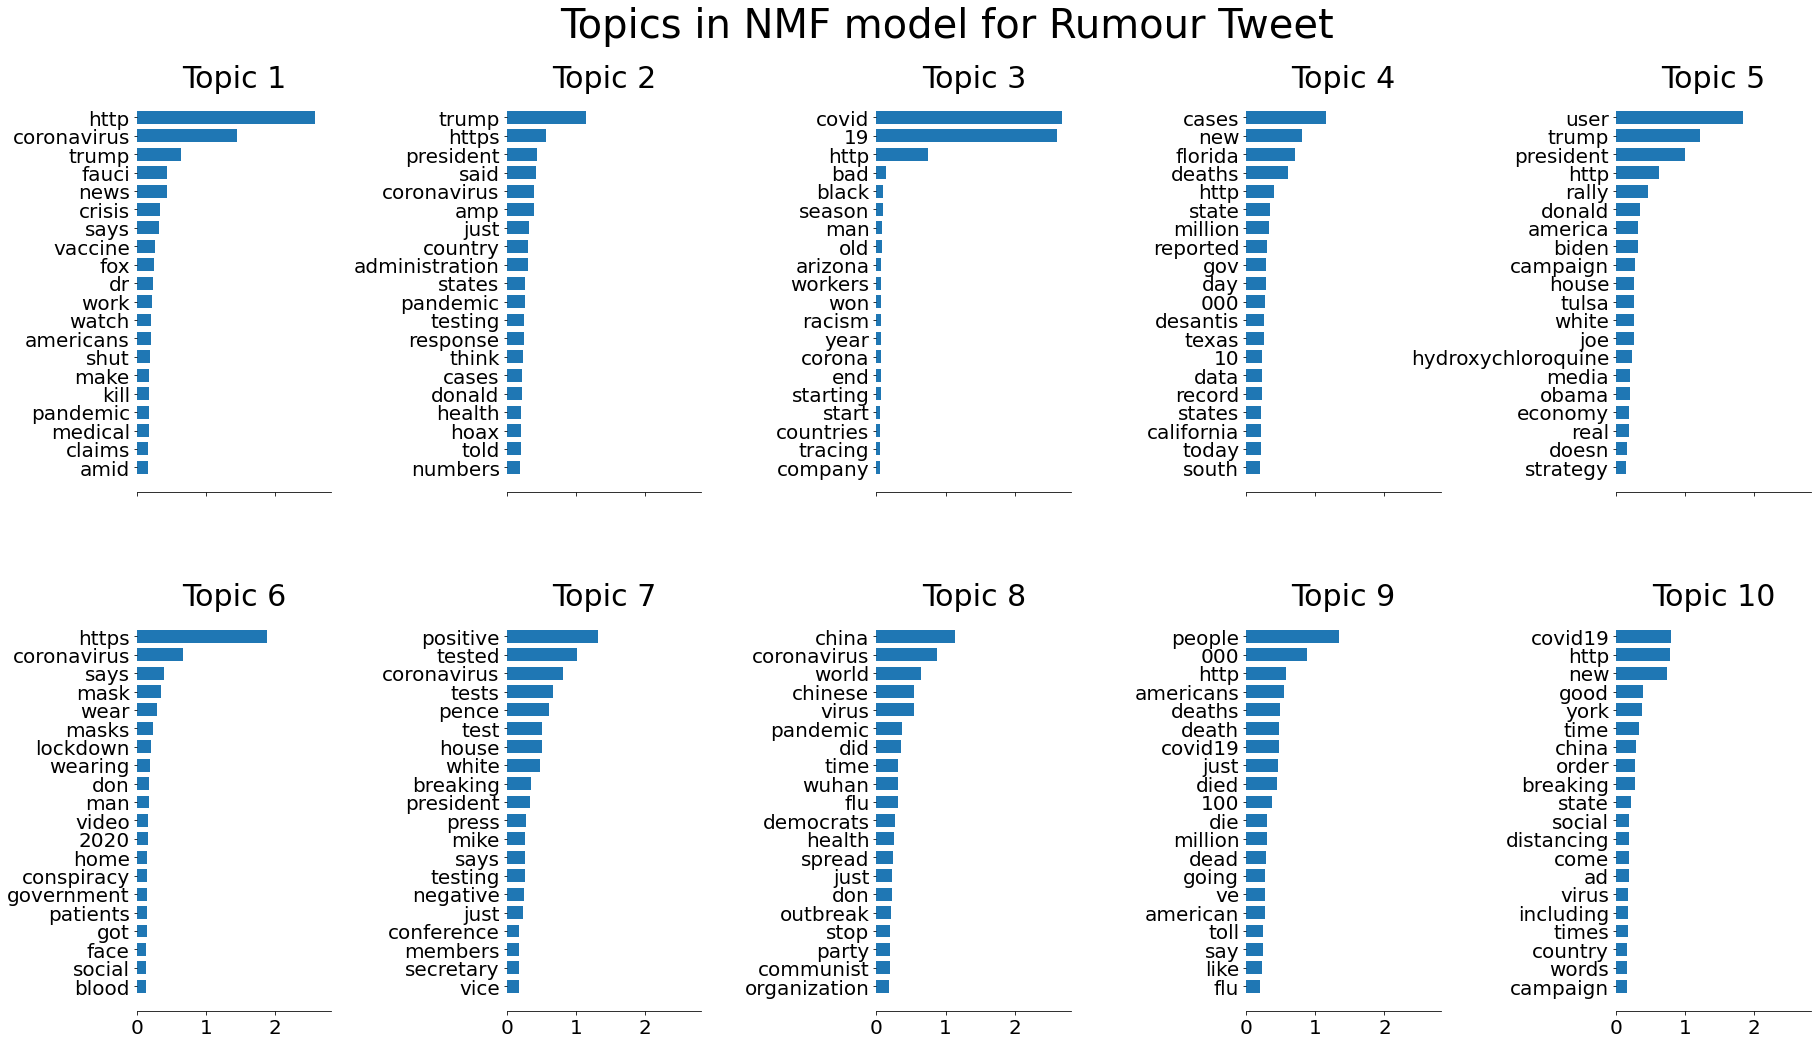

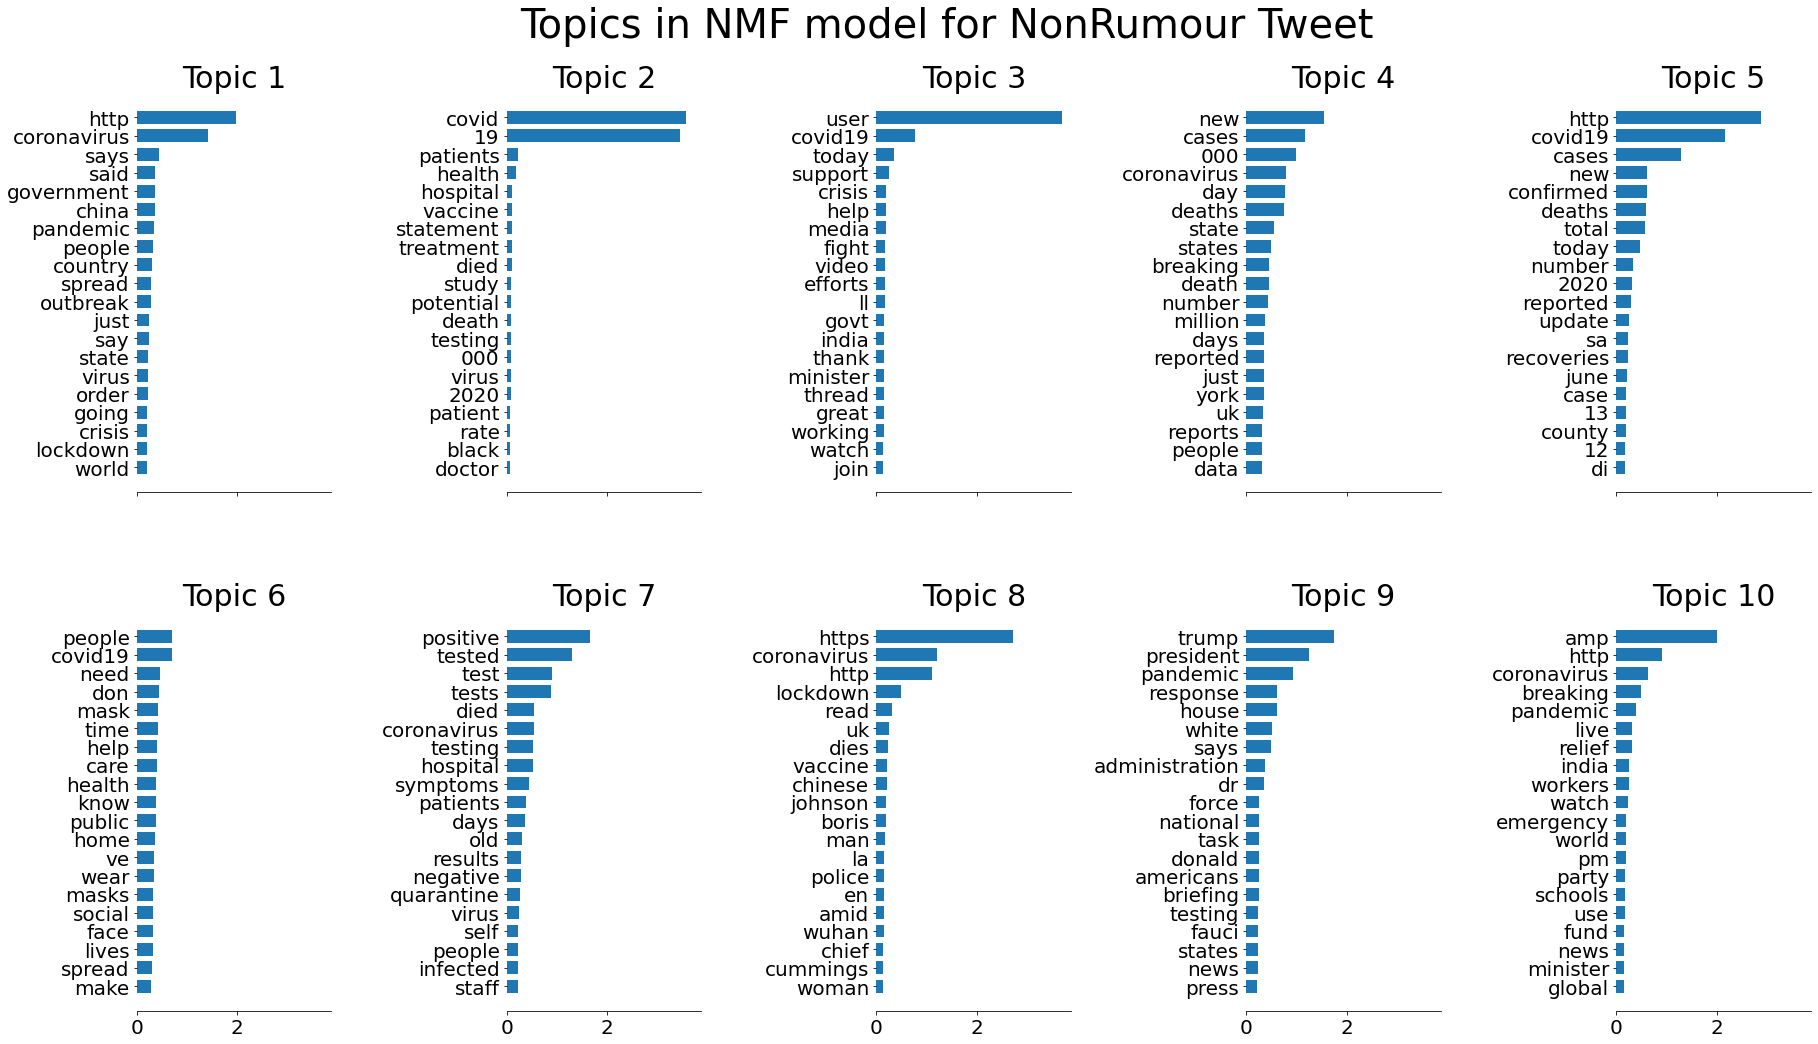

In [8]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Use tf-idf features for NMF.
rumour_tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)

nonrumour_tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)

rumour_tfidf = rumour_tfidf_vectorizer.fit_transform(rumour_text)
nonrumour_tfidf = nonrumour_tfidf_vectorizer.fit_transform(nonrumour_text)

# Fit the NMF model

rumour_nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(rumour_tfidf)

nonrumour_nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(nonrumour_tfidf)

rumour_tfidf_feature_names = rumour_tfidf_vectorizer.get_feature_names()
nonrumour_tfidf_feature_names = nonrumour_tfidf_vectorizer.get_feature_names()

plot_top_words(
    rumour_nmf,
    rumour_tfidf_feature_names,
    n_top_words,
    "Topics in NMF model for Rumour Tweet",
)

plot_top_words(
    nonrumour_nmf,
    nonrumour_tfidf_feature_names,
    n_top_words,
    "Topics in NMF model for NonRumour Tweet",
)

### Hashtag

In [9]:
rumour_hashtags = dict()
nonrumour_hashtags = dict()

for x in rumour_list:
    if "entities" in x and "hashtags" in x["entities"]:
        for y in x["entities"]["hashtags"]:
            tag = y["tag"].lower()
            rumour_hashtags[tag] = rumour_hashtags.get(tag, 0) + 1

for x in nonrumour_list:
    if "entities" in x and "hashtags" in x["entities"]:
        for y in x["entities"]["hashtags"]:
            tag = y["tag"].lower()
            nonrumour_hashtags[tag] = nonrumour_hashtags.get(tag, 0) + 1
            
rumour_sorted_hashtags = sorted(rumour_hashtags.items(), key=lambda wc: wc[1], reverse=True)[:20]
nonrumour_sorted_hashtags = sorted(nonrumour_hashtags.items(), key=lambda wc: wc[1], reverse=True)[:20]


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


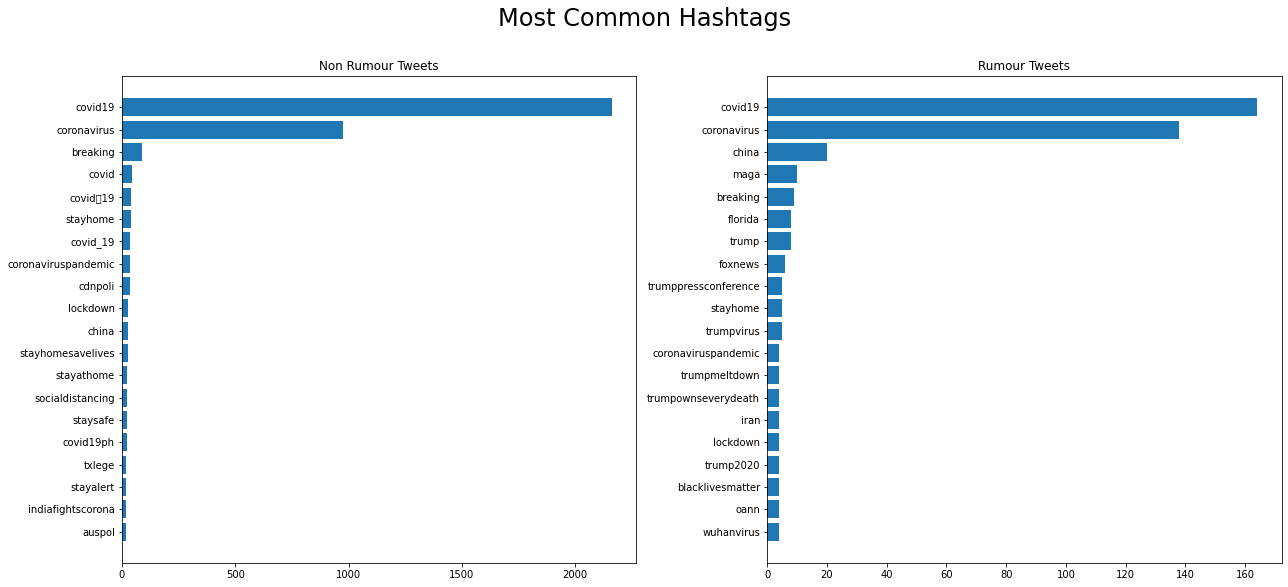

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

axes[0].barh(y=range(20),
             width=[i[1] for i in nonrumour_sorted_hashtags],
             tick_label=[i[0] for i in nonrumour_sorted_hashtags],
            )
axes[1].barh(y=range(20),
             width=[i[1] for i in rumour_sorted_hashtags],
             tick_label=[i[0] for i in rumour_sorted_hashtags],
            )
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')
fig.suptitle('Most Common Hashtags', fontsize=24, va='baseline')
plt.tight_layout()

### Sentiment Analysis

In [11]:
# import nltk
# nltk.download('vader_lexicon')

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [13]:
print(rumour_text[0])
print(sia.polarity_scores(rumour_text[0]))

Monkeys on the loose in India with stolen coronavirus blood samples http http
{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.6705}


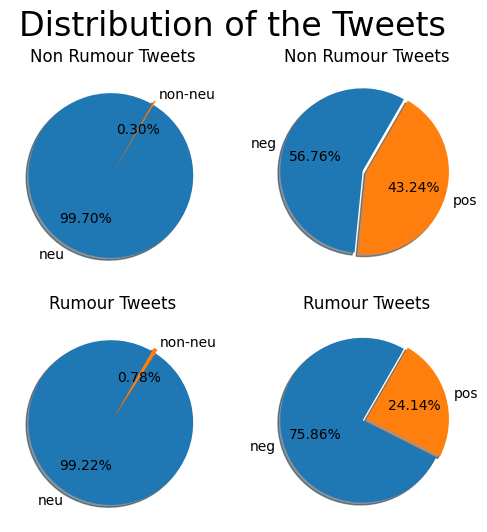

In [14]:
# 'neg': 0, 'neu': 1 'pos':2
rumour_sentiments = [0, 0, 0]
for t in rumour_text:
    score = sia.polarity_scores(t)
    if score["neg"] > score["pos"] and score["neg"] > score["neu"]:
        rumour_sentiments[0] += 1
    elif score["pos"] > score["neg"] and score["pos"] > score["neu"]:
        rumour_sentiments[2] += 1
    else:
        rumour_sentiments[1] += 1

nonrumour_sentiments = [0, 0, 0]
for t in nonrumour_text:
    score = sia.polarity_scores(t)
    if score["neg"] > score["pos"] and score["neg"] > score["neu"]:
        nonrumour_sentiments[0] += 1
    elif score["pos"] > score["neg"] and score["pos"] > score["neu"]:
        nonrumour_sentiments[2] += 1
    else:
        nonrumour_sentiments[1] += 1

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), dpi=100)
axes[0, 0].pie([nonrumour_sentiments[1], nonrumour_sentiments[0] + nonrumour_sentiments[2]],
            labels=['neu', 'non-neu'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)


axes[0, 1].pie([nonrumour_sentiments[0], nonrumour_sentiments[2]],
            labels=['neg', 'pos'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
axes[1, 0].pie([rumour_sentiments[1], rumour_sentiments[0] + rumour_sentiments[2]],
            labels=['neu', 'non-neu'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)


axes[1, 1].pie([rumour_sentiments[0], rumour_sentiments[2]],
            labels=['neg', 'pos'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
axes[0, 0].set_title('Non Rumour Tweets')
axes[0, 1].set_title('Non Rumour Tweets')
axes[1, 0].set_title('Rumour Tweets')
axes[1, 1].set_title('Rumour Tweets')
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

### Other Analysis Tips

In [ ]:
# ! pip install spacy

In [15]:
# Spacy
#pip install spacy && python -m spacy download en_core_web_sm
import spacy

'''
NLP tasks:
1.tokenization
2.part of speech tagging
3.chunking
'''
#load the language model for English
nlp = spacy.load('en_core_web_sm')

doc1 = nlp(u"Monkeys on the loose in India with stolen coronavirus blood samples https://t.co/UY3xCVxrpW https://t.co/AXDHmk1wH4")

# test tokenization and POS tagging
# https://spacy.io/api/token?
for token in doc1:
    if not token.is_stop : # filter stop words
        print(token.text, token.pos_, token.lemma_)


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [16]:
tweet_json = rumour_list[0]
print(tweet_json)
# Contains details about annotations relative to the text within a Tweet.
# https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets
for i in tweet_json["entities"]["annotations"]:
    print(i["normalized_text"])


print(tweet_json["public_metrics"])

{'text': 'Monkeys on the loose in India with stolen coronavirus blood samples https://t.co/UY3xCVxrpW https://t.co/AXDHmk1wH4', 'entities': {'urls': [{'start': 68, 'end': 91, 'url': 'https://t.co/UY3xCVxrpW', 'expanded_url': 'http://hill.cm/Cc349cN', 'display_url': 'hill.cm/Cc349cN'}, {'start': 92, 'end': 115, 'url': 'https://t.co/AXDHmk1wH4', 'expanded_url': 'https://twitter.com/thehill/status/1266555444283179008/photo/1', 'display_url': 'pic.twitter.com/AXDHmk1wH4'}], 'annotations': [{'start': 24, 'end': 28, 'probability': 0.9982, 'type': 'Place', 'normalized_text': 'India'}]}, 'context_annotations': [{'domain': {'id': '47', 'name': 'Brand', 'description': 'Brands and Companies'}, 'entity': {'id': '1100053375620534275', 'name': 'The Hill', 'description': 'The Hill'}}, {'domain': {'id': '123', 'name': 'Ongoing News Story', 'description': "Ongoing News Stories like 'Brexit'"}, 'entity': {'id': '1220701888179359745', 'name': 'COVID-19'}}], 'id': '1266555444283179008', 'conversation_id':

In [ ]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
text = "Covid cases are increasing fast!"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")